# COVID-19 and Weather Patterns

## Imports

- *os* for interfacing with the operating system
- *pathlib* for interfacing with the file system
- *zipfile* for managing archive files

- *numpy* for array processing
- *pandas* for tabular processing
- *tensorflow* for tensor processing
- *keras* for simplified tensor processing

- *matplotlib* for visualization
- *seaborn* for enhanced visualization

In [1]:
# Custom
import data_processing

# File System
import os
import json
from pathlib import Path
from zipfile import ZipFile
import pickle

# Processing
import gc
import numpy as np
import pandas as pd
from sympy import *
from sympy.geometry import *
import tensorflow
from tensorflow import keras

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

tensorflow.__version__

2021-11-28 17:38:44.031170: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 
2021-11-28 17:38:44.031194: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


'2.7.0'

## Introduction

The goal of this work is to determine whether or not weather patterns should be considered as a meaningful supporting input when making predictions about new daily COVID-19 cases within a given geographical space. Using census, weather, and COVID-19 datasets provided by the Urban Sustain project, the authors attempt to quantify the correlation between particular weather patterns and COVID-19 transmission events.

## Defining Terms

***Urban Sustain Project*** - A joint effort between researchers at Colorado State University, Arizona State University, the University of California-Irvine, and the University of Maryland – Baltimore County.

## Loading Data

**DEVELOPER NOTE:** Download the five required datasets from Urban Sustain and place them in the cloned repository at ```./data/```. These datasets are also available at a shared OneDrive folder. This logic expects that these files exist at relative path ```../data/``` with respect to this notebook.

We'll begin by defining a path to our data directory and a list of the datasets that we expect to find there.

In [2]:
DATA_PATH = '../data/' # Point this constant to the location of your data archive files

EXPECTED_DATASETS = [
    'county_total_population.Colorado.zip',
    'covid_county.Colorado.zip',
    'neon_2d_wind.Colorado.zip',
    'neon_barometric_pressure.Colorado.zip',
    'neon_single_asp_air_temperature.Colorado.zip'
]

Next, we will attempt to extract each of these archived datasets into a dedicated subdirectory within the given data directory.

In [4]:
# For each listed dataset string in the EXPECTED_DATASETS constant
for datasetName in EXPECTED_DATASETS:
    try:
        # Open the given archive file
        with ZipFile(DATA_PATH + datasetName, 'r') as currentZip:
            # Build the target directory path for extracted data
            datasetNameTokens = datasetName.split('.')
            datasetNameTokens.remove('zip')
            targetDirectory = DATA_PATH + '.'.join(datasetNameTokens)
            
            # If the target directory doesn't exist, create it
            if not os.path.exists(targetDirectory):
                Path(targetDirectory).mkdir()
            
            # Extract all data from the archive file to the target directory
            currentZip.extractall(targetDirectory)
    except FileNotFoundError:
        print("Unable to open " + datasetName + " at path " + DATA_PATH + datasetName)

## File Information

Four of the five datasets referenced in this work relate geospatial information to particular events as they occur over time Each is provided by the Urban Sustain project and employs a similar file structure.

- data.json
- fieldLabels.json
- linkedGeometry.json
- README.txt


#### New York Times COVID-19 County Dataset

The included COVID-19 County dataset 

In [5]:
covidDataFrame = pd.io.json.read_json('../data/covid_county.Colorado/data.json')
covidDataFrame.sample(5)

,_id,GISJOIN,epoch_time,dateString,county,state,totalCaseCount,newCaseCount,totalDeathCount,newDeathCount
4233,{'$oid': '615fc624bf06594c4cad535d'},G0800130,{'$numberLong': '1631512800000'},9/13/21,Boulder,Colorado,27430,210,241,1
2606,{'$oid': '615fc624bf06594c4cad4c2b'},G0800090,{'$numberLong': '1580281200000'},1/29/20,Baca,Colorado,0,0,0,0
37562,{'$oid': '615fc628bf06594c4cadd870'},G0801190,{'$numberLong': '1609657200000'},1/3/21,Teller,Colorado,1000,3,9,0
38918,{'$oid': '615fc628bf06594c4caddf62'},G0801230,{'$numberLong': '1601791200000'},10/4/20,Weld,Colorado,4949,40,151,0
14716,{'$oid': '615fc625bf06594c4cad7bad'},G0800450,{'$numberLong': '1606806000000'},12/1/20,Garfield,Colorado,2280,34,9,2


In [6]:
covidLabelsFrame = pd.io.json.read_json('../data/covid_county.Colorado/fieldLabels.json')
covidLabelsFrame.sample(5)

,name,label
1,newDeathCount,New Death Count
3,newCaseCount,New Case Count
2,totalDeathCount,Total Death Count
0,epoch_time,Date
4,totalCaseCount,Total Case Count


In [7]:
covidGeometryFrame = pd.io.json.read_json('../data/covid_county.Colorado/linkedGeometry.json')
covidGeometryFrame.sample(5)

,_id,type,geometry,properties,GISJOIN
56,{'$oid': '604964eefed2e95d6b68b9c7'},Feature,"{'type': 'Polygon', 'coordinates': [[[-107.568...","{'STATEFP10': '08', 'COUNTYFP10': '111', 'COUN...",G0801110
22,{'$oid': '604964ecfed2e95d6b68b55f'},Feature,"{'type': 'Polygon', 'coordinates': [[[-105.329...","{'STATEFP10': '08', 'COUNTYFP10': '043', 'COUN...",G0800430
53,{'$oid': '604964eefed2e95d6b68b837'},Feature,"{'type': 'Polygon', 'coordinates': [[[-106.038...","{'STATEFP10': '08', 'COUNTYFP10': '105', 'COUN...",G0801050
44,{'$oid': '604964ecfed2e95d6b68b67a'},Feature,"{'type': 'Polygon', 'coordinates': [[[-103.581...","{'STATEFP10': '08', 'COUNTYFP10': '087', 'COUN...",G0800870
52,{'$oid': '604964ecfed2e95d6b68b681'},Feature,"{'type': 'Polygon', 'coordinates': [[[-107.439...","{'STATEFP10': '08', 'COUNTYFP10': '103', 'COUN...",G0801030


#### NEON 2D Wind Dataset

In [8]:
windDataFrame = pd.io.json.read_json('../data/neon_2d_wind.Colorado/data.json')
windDataFrame.sample(5)

,_id,site,epoch_time,startDateTime,endDateTime,windSpeedMean,windSpeedMinimum,windSpeedMaximum,windSpeedVariance,windSpeedNumPts,windSpeedExpUncert,windSpeedStdErMean,windSpeedFinalQF,windDirMean,windDirVariance,windDirNumPts,windDirExpUncert,windDirStdErMean,windDirFinalQF
202326,{'$oid': '60cbc07251c1683b4629a48b'},CPER_DP1.00001.001_000.010,{'$numberLong': '1479535200000'},2016-11-19T06:00:00Z,2016-11-19T06:30:00Z,0.38,0.01,0.93,0.02,1800,0.02,0.00,0,40.82,499.71,1800,0.07,0.05,0
682283,{'$oid': '60cbc6fc51c1683b46dfc098'},NIWO_DP1.00001.001_000.030,{'$numberLong': '1595437200000'},2020-07-22T17:00:00Z,2020-07-22T17:30:00Z,6.16,2.15,10.47,2.17,1800,0.40,0.03,0,286.17,172.01,1800,0.07,0.01,0
590710,{'$oid': '60cbc6f151c1683b46de8d7f'},NIWO_DP1.00001.001_000.020,{'$numberLong': '1544445000000'},2018-12-10T12:30:00Z,2018-12-10T13:00:00Z,7.32,2.52,12.90,2.15,1800,0.54,0.03,0,300.60,50.10,1800,0.07,0.00,0
436547,{'$oid': '60cbc07151c1683b46297e52'},CPER_DP1.00001.001_000.030,{'$numberLong': '1472455800000'},2016-08-29T07:30:00Z,2016-08-29T08:00:00Z,2.30,0.87,3.43,0.53,1800,0.07,0.02,0,330.19,80.50,1800,0.07,0.01,1
909732,{'$oid': '60cbc27551c1683b466183ad'},RMNP_DP1.00001.001_000.030,{'$numberLong': '1441013400000'},2015-08-31T09:30:00Z,2015-08-31T10:00:00Z,1.11,0.02,4.57,0.54,1800,0.09,0.02,0,340.10,6145.44,1800,0.07,0.05,1


In [9]:
windLabelsFrame = pd.io.json.read_json('../data/neon_2d_wind.Colorado/fieldLabels.json')
windLabelsFrame.sample(5)

,name,label
15,windSpeedPersistenceNAQM,Wind speed quality metric that summarizes when...
20,windSpeedGapPassQM,Wind speed quality metric that summarizes the ...
18,windSpeedNullNAQM,Wind speed quality metric that summarizes when...
22,windSpeedSensorErrorFailQM,Wind speed quality metric that summarizes the ...
29,windSpeedBetaQM,Wind speed quality metric detailing the outcom...


In [10]:
windGeometryFrame = pd.io.json.read_json('../data/neon_2d_wind.Colorado/linkedGeometry.json')
windGeometryFrame.sample(5)

,_id,type,geometry,properties,site
11,{'$oid': '60cbcf5eed5577c25c20520a'},Feature,"{'type': 'Point', 'coordinates': [-103.02929, ...","{'HOR.VER': '000.030', 'name': 'CFGLOC100115',...",STER_DP1.00001.001_000.030
12,{'$oid': '60cbcf5eed5577c25c205209'},Feature,"{'type': 'Point', 'coordinates': [-103.02929, ...","{'HOR.VER': '000.020', 'name': 'CFGLOC100114',...",STER_DP1.00001.001_000.020
5,{'$oid': '60cbcf5eed5577c25c205294'},Feature,"{'type': 'Point', 'coordinates': [-105.58238, ...","{'HOR.VER': '000.010', 'name': 'CFGLOC109345',...",NIWO_DP1.00001.001_000.010
1,{'$oid': '60cbcf5eed5577c25c205233'},Feature,"{'type': 'Point', 'coordinates': [-105.545955,...","{'HOR.VER': '000.040', 'name': 'CFGLOC100675',...",RMNP_DP1.00001.001_000.040
4,{'$oid': '60cbcf5eed5577c25c205282'},Feature,"{'type': 'Point', 'coordinates': [-105.544602,...","{'HOR.VER': '200.000', 'name': 'CFGLOC101555',...",COMO_DP1.00001.001_200.000


#### NEON Barometric Pressure Dataset

In [11]:
pressureDataFrame = pd.io.json.read_json('../data/neon_barometric_pressure.Colorado/data.json')
pressureDataFrame.sample(5)

,_id,site,epoch_time,startDateTime,endDateTime,staPresMean,staPresMinimum,staPresMaximum,staPresVariance,staPresNumPts,staPresExpUncert,staPresStdErMean,staPresFinalQF,corPres,corPresExpUncert,corPresFinalQF
38382,{'$oid': '60c78aaec8cb4f3f3be200a2'},ARIK_DP1.00004.001,{'$numberLong': '1562302800000'},2019-07-05T05:00:00Z,2019-07-05T05:30:00Z,88.00533,87.89830,88.06834,0.00246,180,0.01872,0.00370,0,100.73027,0.08688,0
90526,{'$oid': '60c78b04c8cb4f3f3bebfde3'},COMO_DP1.00004.001,{'$numberLong': '1533609000000'},2018-08-07T02:30:00Z,2018-08-07T03:00:00Z,71.53532,71.53215,71.54218,0.00002,180,0.01721,0.00035,0,101.51318,0.47989,0
491275,{'$oid': '60c78d47c8cb4f3f3b2e570a'},WLOU_DP1.00004.001,{'$numberLong': '1520987400000'},2018-03-14T00:30:00Z,2018-03-14T01:00:00Z,71.55629,71.55012,71.56013,0.00002,180,0.01722,0.00036,0,102.06305,0.49228,0
383044,{'$oid': '60c78ca2c8cb4f3f3b1b9dc7'},RMNP_DP1.00004.001,{'$numberLong': '1613698200000'},2021-02-19T01:30:00Z,2021-02-19T02:00:00Z,72.68546,72.64995,72.70997,0.00018,180,0.04725,0.00100,0,102.82366,0.48531,0
506272,{'$oid': '60c78d49c8cb4f3f3b2e9343'},WLOU_DP1.00004.001,{'$numberLong': '1549906200000'},2019-02-11T17:30:00Z,2019-02-11T18:00:00Z,70.19067,70.14460,70.23463,0.00064,180,0.01761,0.00189,0,101.05051,0.51284,0


In [12]:
pressureLabelsFrame = pd.io.json.read_json('../data/neon_barometric_pressure.Colorado/fieldLabels.json')
pressureLabelsFrame.sample(5)

,name,label
24,staPresGapNAQM,Station pressure quality metric that summarize...
12,staPresRangeNAQM,Station pressure quality metric that summarize...
4,staPresMinimum,Minimum Station Pressure
22,staPresGapFailQM,Station pressure quality metric that summarize...
30,staPresValidCalNAQM,Station pressure quality metric that summarize...


In [13]:
pressureGeometryFrame = pd.io.json.read_json('../data/neon_barometric_pressure.Colorado/linkedGeometry.json')
pressureGeometryFrame.sample(5)

,_id,type,geometry,properties,site
2,{'$oid': '60c78a9d230c7f49850c20b0'},Feature,"{'type': 'Point', 'coordinates': [-105.544602,...","{'site': 'COMO_DP1.00004.001', 'name': 'neon_b...",COMO_DP1.00004.001
3,{'$oid': '60c78a9d230c7f49850c20cf'},Feature,"{'type': 'Point', 'coordinates': [-105.58238, ...","{'site': 'NIWO_DP1.00004.001', 'name': 'neon_b...",NIWO_DP1.00004.001
0,{'$oid': '60c78a9d230c7f49850c20dc'},Feature,"{'type': 'Point', 'coordinates': [-105.545955,...","{'site': 'RMNP_DP1.00004.001', 'name': 'neon_b...",RMNP_DP1.00004.001
6,{'$oid': '60c78a9d230c7f49850c20a5'},Feature,"{'type': 'Point', 'coordinates': [-102.450966,...","{'site': 'ARIK_DP1.00004.001', 'name': 'neon_b...",ARIK_DP1.00004.001
1,{'$oid': '60c78a9d230c7f49850c20ef'},Feature,"{'type': 'Point', 'coordinates': [-105.914674,...","{'site': 'WLOU_DP1.00004.001', 'name': 'neon_b...",WLOU_DP1.00004.001


#### NEON Air Temperature

In [14]:
temperatureDataFrame = pd.io.json.read_json('../data/neon_single_asp_air_temperature.Colorado/data.json')
temperatureDataFrame.sample(5)

,_id,site,epoch_time,startDateTime,endDateTime,tempSingleMean,tempSingleMinimum,tempSingleMaximum,tempSingleVariance,tempSingleNumPts,tempSingleExpUncert,tempSingleStdErMean,finalQF
13519,{'$oid': '60cbd73c0fc3818c81479773'},ARIK_DP1.00002.001_200.000,{'$numberLong': '1488965400000'},2017-03-08T09:30:00Z,2017-03-08T10:00:00Z,-2.1882,-3.2797,-1.2826,0.2856,1800,0.1360,0.0126,0
1130440,{'$oid': '60cbd3b20fc3818c81dc34e6'},STER_DP1.00002.001_000.020,{'$numberLong': '1575334800000'},2019-12-03T01:00:00Z,2019-12-03T01:30:00Z,-0.1806,-0.6655,0.3051,0.0614,1800,0.1347,0.0058,0
1025784,{'$oid': '60cbd3ae0fc3818c81dbcd60'},STER_DP1.00002.001_000.010,{'$numberLong': '1560868200000'},2019-06-18T14:30:00Z,2019-06-18T15:00:00Z,14.1193,13.9854,14.2614,0.0037,1800,0.1401,0.0014,0
632201,{'$oid': '60cbd5290fc3818c8108f511'},RMNP_DP1.00002.001_000.010,{'$numberLong': '1511742600000'},2017-11-27T00:30:00Z,2017-11-27T01:00:00Z,2.6758,1.9395,3.4957,0.1441,1800,0.1369,0.0089,0
812083,{'$oid': '60cbd5260fc3818c81088fc5'},RMNP_DP1.00002.001_000.030,{'$numberLong': '1495630800000'},2017-05-24T13:00:00Z,2017-05-24T13:30:00Z,10.3725,9.2370,11.1739,0.3350,1800,0.1416,0.0136,0


In [15]:
temperatureLabelsFrame = pd.io.json.read_json('../data/neon_single_asp_air_temperature.Colorado/fieldLabels.json')
temperatureLabelsFrame.sample(5)

,name,label
37,alphaQM,Quality metric detailing the outcomes of the a...
20,nullPassQM,Quality metric that summarizes the passed outc...
1,startDateTime,Date and time at which a sampling is initiated
16,stepFailQM,Quality metric that summarizes the failed outc...
15,persistenceNAQM,Quality metric that summarizes when the persis...


In [16]:
temperatureGeometryFrame = pd.io.json.read_json('../data/neon_single_asp_air_temperature.Colorado/linkedGeometry.json')
temperatureGeometryFrame.sample(5)

,_id,type,geometry,properties,site
8,{'$oid': '60cbd3907adbc5ff35cc422e'},Feature,"{'type': 'Point', 'coordinates': [-105.58238, ...","{'HOR.VER': '000.020', 'name': 'CFGLOC109351',...",NIWO_DP1.00002.001_000.020
12,{'$oid': '60cbd3907adbc5ff35cc41a1'},Feature,"{'type': 'Point', 'coordinates': [-103.02929, ...","{'HOR.VER': '000.010', 'name': 'CFGLOC100016',...",STER_DP1.00002.001_000.010
6,{'$oid': '60cbd3907adbc5ff35cc422f'},Feature,"{'type': 'Point', 'coordinates': [-105.58238, ...","{'HOR.VER': '000.030', 'name': 'CFGLOC109358',...",NIWO_DP1.00002.001_000.030
13,{'$oid': '60cbd3907adbc5ff35cc41a3'},Feature,"{'type': 'Point', 'coordinates': [-103.02929, ...","{'HOR.VER': '000.030', 'name': 'CFGLOC100018',...",STER_DP1.00002.001_000.030
15,{'$oid': '60cbd3907adbc5ff35cc4201'},Feature,"{'type': 'Point', 'coordinates': [-102.450966,...","{'HOR.VER': '200.000', 'name': 'CFGLOC101255',...",ARIK_DP1.00002.001_200.000


### U.S. Census Total County Population Dataset

In [17]:
populationDataFrame = pd.io.json.read_json('../data/county_total_population.Colorado/data.json')
populationDataFrame

,_id,GISJOIN,STATE,STATEFP,STATENH,COUNTY,COUNTYFP,COUNTYNH,1980_total_population,1990_total_population,2000_total_population,2010_total_population
0,{'$oid': '607d4c2708e81eceb6b6e384'},G0800010,Colorado,8,80,Adams County,1,10,245944,265038,363857,441603
1,{'$oid': '607d4c2708e81eceb6b6e385'},G0800030,Colorado,8,80,Alamosa County,3,30,11799,13617,14966,15445
2,{'$oid': '607d4c2708e81eceb6b6e386'},G0800050,Colorado,8,80,Arapahoe County,5,50,293621,391511,487967,572003
3,{'$oid': '607d4c2708e81eceb6b6e387'},G0800070,Colorado,8,80,Archuleta County,7,70,3664,5345,9898,12084
4,{'$oid': '607d4c2708e81eceb6b6e388'},G0800090,Colorado,8,80,Baca County,9,90,5419,4556,4517,3788
...,...,...,...,...,...,...,...,...,...,...,...,...
58,{'$oid': '607d4c2708e81eceb6b6e3bf'},G0801170,Colorado,8,80,Summit County,117,1170,8848,12881,23548,27994
59,{'$oid': '607d4c2708e81eceb6b6e3c4'},G0801190,Colorado,8,80,Teller County,119,1190,8034,12468,20555,23350
60,{'$oid': '607d4c2708e81eceb6b6e3c3'},G0801210,Colorado,8,80,Washington County,121,1210,5304,4812,4926,4814
61,{'$oid': '607d4c2708e81eceb6b6e3c2'},G0801230,Colorado,8,80,Weld County,123,1230,123438,131821,180936,252825


In [18]:
populationLabelsFrame = pd.io.json.read_json('../data/county_total_population.Colorado/fieldLabels.json')
populationLabelsFrame

""


In [19]:
populationGeometryFrame = pd.io.json.read_json('../data/county_total_population.Colorado/linkedGeometry.json')
populationGeometryFrame

,_id,type,geometry,properties,GISJOIN
0,{'$oid': '604964ecfed2e95d6b68b676'},Feature,"{'type': 'Polygon', 'coordinates': [[[-104.961...","{'STATEFP10': '08', 'COUNTYFP10': '001', 'COUN...",G0800010
1,{'$oid': '604964ecfed2e95d6b68b684'},Feature,"{'type': 'Polygon', 'coordinates': [[[-105.457...","{'STATEFP10': '08', 'COUNTYFP10': '003', 'COUN...",G0800030
2,{'$oid': '604964eefed2e95d6b68bb16'},Feature,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...","{'STATEFP10': '08', 'COUNTYFP10': '005', 'COUN...",G0800050
3,{'$oid': '604964eefed2e95d6b68b9c8'},Feature,"{'type': 'Polygon', 'coordinates': [[[-107.128...","{'STATEFP10': '08', 'COUNTYFP10': '007', 'COUN...",G0800070
4,{'$oid': '604964eefed2e95d6b68b83d'},Feature,"{'type': 'Polygon', 'coordinates': [[[-102.747...","{'STATEFP10': '08', 'COUNTYFP10': '009', 'COUN...",G0800090
...,...,...,...,...,...
59,{'$oid': '604964ecfed2e95d6b68b677'},Feature,"{'type': 'Polygon', 'coordinates': [[[-105.924...","{'STATEFP10': '08', 'COUNTYFP10': '117', 'COUN...",G0801170
60,{'$oid': '604964eefed2e95d6b68b840'},Feature,"{'type': 'Polygon', 'coordinates': [[[-105.329...","{'STATEFP10': '08', 'COUNTYFP10': '119', 'COUN...",G0801190
61,{'$oid': '604964eefed2e95d6b68b9c5'},Feature,"{'type': 'Polygon', 'coordinates': [[[-102.779...","{'STATEFP10': '08', 'COUNTYFP10': '121', 'COUN...",G0801210
62,{'$oid': '604964eefed2e95d6b68b9c3'},Feature,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...","{'STATEFP10': '08', 'COUNTYFP10': '123', 'COUN...",G0801230


## Data Exploration

/s/chopin/k/grad/kbass40/venv/lib64/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='newCaseCount', ylabel='Density'>

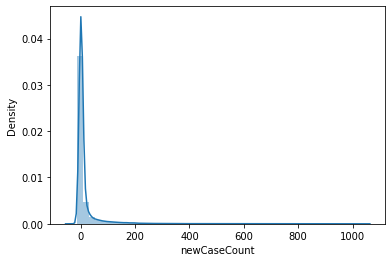

In [20]:
sns.distplot(covidDataFrame.newCaseCount)

/s/chopin/k/grad/kbass40/venv/lib64/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='tempSingleMean', ylabel='Density'>

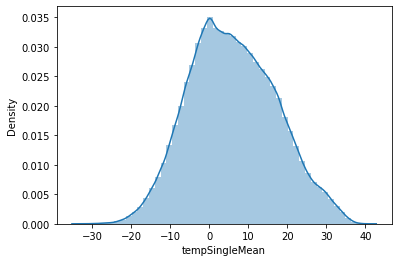

In [21]:
sns.distplot(temperatureDataFrame.tempSingleMean)

#### Garbage Collection

In [22]:
del covidDataFrame
del covidLabelsFrame
del covidGeometryFrame

del windDataFrame
del windLabelsFrame
del windGeometryFrame

del pressureDataFrame
del pressureLabelsFrame
del pressureGeometryFrame

del temperatureDataFrame
del temperatureLabelsFrame
del temperatureGeometryFrame

del populationDataFrame
del populationLabelsFrame
del populationGeometryFrame

gc.collect()

21

## Preprocessing

#### Flatten Frames

In [23]:
flattenedCovidDataFrame = pd.json_normalize(json.load(open(Path('../data/covid_county.Colorado/data.json'))))
flattenedCovidGeometryFrame = pd.json_normalize(json.load(open(Path('../data/covid_county.Colorado/linkedGeometry.json'))))

flattenedWindDataFrame = pd.json_normalize(json.load(open(Path('../data/neon_2d_wind.Colorado/data.json'))))
flattenedWindGeometryFrame = pd.json_normalize(json.load(open(Path('../data/neon_2d_wind.Colorado/linkedGeometry.json'))))

flattenedPressureDataFrame = pd.json_normalize(json.load(open(Path('../data/neon_barometric_pressure.Colorado/data.json'))))
flattenedPressureGeometryFrame = pd.json_normalize(json.load(open(Path('../data/neon_barometric_pressure.Colorado/linkedGeometry.json'))))

flattenedTemperatureDataFrame = pd.json_normalize(json.load(open(Path('../data/neon_single_asp_air_temperature.Colorado/data.json'))))
flattenedTemperatureGeometryFrame = pd.json_normalize(json.load(open(Path('../data/neon_single_asp_air_temperature.Colorado/linkedGeometry.json'))))

flattenedPopulationDataFrame = pd.json_normalize(json.load(open(Path('../data/county_total_population.Colorado/data.json'))))
flattenedPopulationGeometryFrame = pd.json_normalize(json.load(open(Path('../data/county_total_population.Colorado/linkedGeometry.json'))))

#### Generalize Geometry

In [24]:
combinedCovidFrame = flattenedCovidDataFrame.set_index('GISJOIN').join(flattenedCovidGeometryFrame.set_index('GISJOIN'), lsuffix='_data', rsuffix='_geo')

In [25]:
counties = ['Boulder', 'Grand', 'Larimer', 'Logan', 'Weld', 'Yuma']
combinedCovidFrame = combinedCovidFrame[combinedCovidFrame.county.isin(counties)]

In [26]:
def create_county_polygons(combinedCovidFrame):
    county_polygons = []
    df = combinedCovidFrame.groupby('county').first().reindex(columns=['coordJsonString', 'geometry.type', "geometry.coordinates"])
    print(df)
    df['coordJsonString'] = df["geometry.coordinates"].apply(json.dumps)
    for index, row in df[['coordJsonString', 'geometry.type']].iterrows():
        print(f"processing: {index}")
        shape_data = json.loads(row['coordJsonString'])
        county = index
        if row['geometry.type'] == 'MultiPolygon':
            for p in shape_data:
                s = np.asarray(p)[0]
                shape = Polygon(*s)
                county_polygons.append((county, shape))
        elif row['geometry.type'] == 'Polygon':
            s = np.asarray(shape_data)[0]
            shape = Polygon(*s)
            county_polygons.append((county, shape))
        else:
            print(f"Row had geometry type of {row['geometry.type']}, row is {row}")
    return county_polygons

if not os.path.exists(DATA_PATH + '/county_objects.pickle'):
    county_polygons = create_county_polygons(combinedCovidFrame)
    with open(DATA_PATH + '/county_objects.pickle', 'wb') as handle:
        pickle.dump(county_polygons, handle)
else:
    with open(DATA_PATH + '/county_objects.pickle', 'rb') as handle:
        county_polygons = pickle.load(handle)

def lookup_county_from_geometry(county_polygons, geometry):
    point = Point(np.asarray(geometry))
    for county, shape in county_polygons:
        if shape.encloses_point(point):
            print(f"found {county}")
            return county

In [27]:
flattenedPressureGeometryFrame['county'] = flattenedPressureGeometryFrame.apply(lambda row: lookup_county_from_geometry(county_polygons, row['geometry.coordinates']), axis=1)
flattenedWindGeometryFrame['county'] = flattenedWindGeometryFrame.apply(lambda row: lookup_county_from_geometry(county_polygons, row['geometry.coordinates']), axis=1)
flattenedTemperatureGeometryFrame['county'] = flattenedTemperatureGeometryFrame.apply(lambda row: lookup_county_from_geometry(county_polygons, row['geometry.coordinates']), axis=1)

found Larimer
found Grand
found Boulder
found Boulder
found Weld
found Logan
found Yuma
found Larimer
found Larimer
found Larimer
found Larimer
found Boulder
found Boulder
found Boulder
found Boulder
found Weld
found Weld
found Weld
found Logan
found Logan
found Logan
found Yuma
found Larimer
found Larimer
found Larimer
found Larimer
found Grand
found Boulder
found Boulder
found Boulder
found Boulder
found Weld
found Weld
found Weld
found Logan
found Logan
found Logan
found Yuma


#### Join Data and Geometry

In [28]:
combinedWindFrame = flattenedWindDataFrame.set_index('site').join(flattenedWindGeometryFrame.set_index('site'), lsuffix='_data', rsuffix='_geo')
combinedPressureFrame = flattenedPressureDataFrame.set_index('site').join(flattenedPressureGeometryFrame.set_index('site'), lsuffix='_data', rsuffix='_geo')
combinedTemperatureFrame = flattenedTemperatureDataFrame.set_index('site').join(flattenedTemperatureGeometryFrame.set_index('site'), lsuffix='_data', rsuffix='_geo')
combinedPopulationFrame = flattenedPopulationDataFrame.set_index('GISJOIN').join(flattenedPopulationGeometryFrame.set_index('GISJOIN'), lsuffix='_data', rsuffix='_geo')

In [29]:
combinedCovidFrame.to_pickle('../data/control.pkl')
combinedPopulationFrame.to_pickle('../data/population.pkl')

#### Generalize Timing

In [30]:
combinedCovidFrame['date'] = pd.to_datetime(combinedCovidFrame['dateString']).dt.date
combinedWindFrame['date'] = pd.to_datetime(combinedWindFrame['startDateTime']).dt.date
combinedPressureFrame['date'] = pd.to_datetime(combinedPressureFrame['startDateTime']).dt.date
combinedTemperatureFrame['date'] = pd.to_datetime(combinedTemperatureFrame['startDateTime']).dt.date

In [31]:
combinedWindFrame['datetime'] = pd.to_datetime(combinedWindFrame['startDateTime']).dt.round("H")
combinedPressureFrame['datetime'] = pd.to_datetime(combinedPressureFrame['startDateTime']).dt.round("H")
combinedTemperatureFrame['datetime'] = pd.to_datetime(combinedTemperatureFrame['startDateTime']).dt.round("H")

In [32]:
del flattenedCovidDataFrame
del flattenedCovidGeometryFrame

del flattenedWindDataFrame
del flattenedWindGeometryFrame

del flattenedPressureDataFrame
del flattenedPressureGeometryFrame

del flattenedTemperatureDataFrame
del flattenedTemperatureGeometryFrame

del flattenedPopulationDataFrame
del flattenedPopulationGeometryFrame

gc.collect()

195

#### Build Experimental Datasets

In [33]:
finalCovidWindFrame = pd.merge(combinedWindFrame, combinedCovidFrame,  how='left', left_on = ['county', 'date'], right_on = ['county', 'date'])
finalCovidWindFrame.to_pickle('../data/covidWind.pkl')
del finalCovidWindFrame
gc.collect()

0

In [34]:
finalCovidPressureFrame = pd.merge(combinedPressureFrame, combinedCovidFrame,  how='left', left_on = ['county', 'date'], right_on = ['county', 'date'])
finalCovidPressureFrame.to_pickle('../data/covidPressure.pkl')
del finalCovidPressureFrame
gc.collect()

0

In [35]:
finalCovidTemperatureFrame = pd.merge(combinedWindFrame, combinedCovidFrame,  how='left', left_on = ['county', 'date'], right_on = ['county', 'date'])
finalCovidTemperatureFrame.to_pickle('../data/covidTemperature.pkl')
del finalCovidTemperatureFrame
gc.collect()

0

In [36]:
del combinedCovidFrame
del combinedWindFrame
del combinedPressureFrame
del combinedTemperatureFrame
del combinedPopulationFrame
gc.collect()

16

## Training

#### Control

In [2]:
controlFrame = pd.read_pickle('../data/control.pkl')
controlFrame.columns

Index(['dateString', 'county', 'state', 'totalCaseCount', 'newCaseCount',
       'totalDeathCount', 'newDeathCount', '_id.$oid_data',
       'epoch_time.$numberLong', 'type', '_id.$oid_geo', 'geometry.type',
       'geometry.coordinates', 'properties.STATEFP10', 'properties.COUNTYFP10',
       'properties.COUNTYNS10', 'properties.GEOID10', 'properties.NAME10',
       'properties.NAMELSAD10', 'properties.LSAD10', 'properties.CLASSFP10',
       'properties.MTFCC10', 'properties.CSAFP10', 'properties.CBSAFP10',
       'properties.METDIVFP10', 'properties.FUNCSTAT10',
       'properties.ALAND10.$numberLong', 'properties.AWATER10',
       'properties.INTPTLAT10', 'properties.INTPTLON10', 'properties.GISJOIN',
       'properties.Shape_area', 'properties.Shape_len', 'properties.ALAND10'],
      dtype='object')

In [3]:
controlFrame.reset_index(drop=True, inplace=True)

In [4]:
# map county to unique numerical number
controlFrame['county'] = pd.Categorical(controlFrame['county'], categories=controlFrame['county'].unique()).codes

In [5]:
controlFrame.dropna()

,dateString,county,state,totalCaseCount,newCaseCount,totalDeathCount,newDeathCount,_id.$oid_data,epoch_time.$numberLong,type,...,properties.METDIVFP10,properties.FUNCSTAT10,properties.ALAND10.$numberLong,properties.AWATER10,properties.INTPTLAT10,properties.INTPTLON10,properties.GISJOIN,properties.Shape_area,properties.Shape_len,properties.ALAND10


In [6]:
reducedControlFrame = controlFrame[['county', 'totalCaseCount', 'newCaseCount', 'totalDeathCount', 'newDeathCount']]
reducedControlFrame.columns

Index(['county', 'totalCaseCount', 'newCaseCount', 'totalDeathCount',
       'newDeathCount'],
      dtype='object')

In [7]:
X = reducedControlFrame[['county', 'totalCaseCount', 'totalDeathCount', 'newDeathCount']]
T = reducedControlFrame[['newCaseCount']]

T.mean(), T.std()

(newCaseCount    30.816774
 dtype: float64,
 newCaseCount    55.662998
 dtype: float64)

In [8]:
X_train = reducedControlFrame.sample(frac=0.8)
X_test = reducedControlFrame.drop(X_train.index)

Xtrain = X_train[['county', 'totalCaseCount', 'totalDeathCount', 'newDeathCount']].to_numpy()
Ttrain = X_train[['newCaseCount']].to_numpy()
Xtest = X_test[['county', 'totalCaseCount', 'totalDeathCount', 'newDeathCount']].to_numpy()
Ttest = X_test[['newCaseCount']].to_numpy()

Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((2995, 4), (2995, 1), (749, 4), (749, 1))

In [9]:
model = keras.Sequential([
    keras.layers.Dense(64, use_bias=False, activation='relu', input_shape=[len(Xtrain[0])]),
    keras.layers.BatchNormalization(center=True, scale=False),
    keras.layers.Activation('relu'),
    
    keras.layers.Dense(128, use_bias=False, activation='relu'),
    keras.layers.BatchNormalization(center=True, scale=False),
    keras.layers.Activation('relu'),
    
    keras.layers.Dense(256, use_bias=False, activation='relu'),
    keras.layers.BatchNormalization(center=True, scale=False),
    keras.layers.Activation('relu'),
    
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer='sgd', metrics=['accuracy'])

2021-11-28 17:39:16.226813: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-28 17:39:16.227567: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 
2021-11-28 17:39:16.228093: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 
2021-11-28 17:39:16.228577: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 
2021-11-28 17:39:16.229044: W tensorf

In [10]:
model.fit(Xtrain, Ttrain, epochs=1000)

Epoch 1/1000
94/94 [==============================] - 1s 2ms/step - loss: 2596.6638 - accuracy: 0.1078
Epoch 2/1000
94/94 [==============================] - 0s 2ms/step - loss: 2497.4658 - accuracy: 0.0755
Epoch 3/1000
94/94 [==============================] - 0s 2ms/step - loss: 2630.1709 - accuracy: 0.0755
Epoch 4/1000
94/94 [==============================] - 0s 2ms/step - loss: 2746.6660 - accuracy: 0.0755
Epoch 5/1000
94/94 [==============================] - 0s 1ms/step - loss: 2736.3035 - accuracy: 0.0755
Epoch 6/1000
94/94 [==============================] - 0s 2ms/step - loss: 2788.3779 - accuracy: 0.0755
Epoch 7/1000
94/94 [==============================] - 0s 2ms/step - loss: 2737.5425 - accuracy: 0.0755
Epoch 8/1000
94/94 [==============================] - 0s 2ms/step - loss: 2660.6165 - accuracy: 0.0798
Epoch 9/1000
94/94 [==============================] - 0s 2ms/step - loss: 2749.6448 - accuracy: 0.0755
Epoch 10/1000
94/94 [==============================] - 0s 2ms/step - loss

94/94 [==============================] - 0s 2ms/step - loss: 3049.9463 - accuracy: 0.0755
Epoch 80/1000
94/94 [==============================] - 0s 1ms/step - loss: 3052.3967 - accuracy: 0.0755
Epoch 81/1000
94/94 [==============================] - 0s 1ms/step - loss: 3052.8989 - accuracy: 0.0755
Epoch 82/1000
94/94 [==============================] - 0s 2ms/step - loss: 3047.2991 - accuracy: 0.0755
Epoch 83/1000
94/94 [==============================] - 0s 2ms/step - loss: 3125.0408 - accuracy: 0.0755
Epoch 84/1000
94/94 [==============================] - 0s 2ms/step - loss: 2968.8618 - accuracy: 0.0755
Epoch 85/1000
94/94 [==============================] - 0s 2ms/step - loss: 2919.4148 - accuracy: 0.0755
Epoch 86/1000
94/94 [==============================] - 0s 2ms/step - loss: 3038.1062 - accuracy: 0.0755
Epoch 87/1000
94/94 [==============================] - 0s 2ms/step - loss: 3052.8999 - accuracy: 0.0755
Epoch 88/1000
94/94 [==============================] - 0s 2ms/step - loss: 305

94/94 [==============================] - 0s 2ms/step - loss: 3038.4771 - accuracy: 0.0755
Epoch 158/1000
94/94 [==============================] - 0s 2ms/step - loss: 3052.4885 - accuracy: 0.0755
Epoch 159/1000
94/94 [==============================] - 0s 1ms/step - loss: 3053.0447 - accuracy: 0.0755
Epoch 160/1000
94/94 [==============================] - 0s 1ms/step - loss: 3052.9370 - accuracy: 0.0755
Epoch 161/1000
94/94 [==============================] - 0s 2ms/step - loss: 3052.2090 - accuracy: 0.0755
Epoch 162/1000
94/94 [==============================] - 0s 1ms/step - loss: 3052.6377 - accuracy: 0.0755
Epoch 163/1000
94/94 [==============================] - 0s 1ms/step - loss: 3053.1628 - accuracy: 0.0755
Epoch 164/1000
94/94 [==============================] - 0s 2ms/step - loss: 3053.0762 - accuracy: 0.0755
Epoch 165/1000
94/94 [==============================] - 0s 2ms/step - loss: 3053.0969 - accuracy: 0.0755
Epoch 166/1000
94/94 [==============================] - 0s 2ms/step - 

94/94 [==============================] - 0s 2ms/step - loss: 3071.2688 - accuracy: 0.0755
Epoch 236/1000
94/94 [==============================] - 0s 2ms/step - loss: 3052.7786 - accuracy: 0.0755
Epoch 237/1000
94/94 [==============================] - 0s 2ms/step - loss: 3052.7991 - accuracy: 0.0755
Epoch 238/1000
94/94 [==============================] - 0s 2ms/step - loss: 3052.9399 - accuracy: 0.0755
Epoch 239/1000
94/94 [==============================] - 0s 2ms/step - loss: 3017.9707 - accuracy: 0.0755
Epoch 240/1000
94/94 [==============================] - 0s 2ms/step - loss: 3019.3708 - accuracy: 0.0755
Epoch 241/1000
94/94 [==============================] - 0s 2ms/step - loss: 3064.8777 - accuracy: 0.0755
Epoch 242/1000
94/94 [==============================] - 0s 1ms/step - loss: 3053.2542 - accuracy: 0.0755
Epoch 243/1000
94/94 [==============================] - 0s 2ms/step - loss: 3053.2463 - accuracy: 0.0755
Epoch 244/1000
94/94 [==============================] - 0s 2ms/step - 

94/94 [==============================] - 0s 1ms/step - loss: 3053.0088 - accuracy: 0.0755
Epoch 314/1000
94/94 [==============================] - 0s 2ms/step - loss: 3053.0361 - accuracy: 0.0755
Epoch 315/1000
94/94 [==============================] - 0s 2ms/step - loss: 3053.2007 - accuracy: 0.0755
Epoch 316/1000
94/94 [==============================] - 0s 2ms/step - loss: 3052.6812 - accuracy: 0.0755
Epoch 317/1000
94/94 [==============================] - 0s 2ms/step - loss: 3049.3181 - accuracy: 0.0755
Epoch 318/1000
94/94 [==============================] - 0s 2ms/step - loss: 3053.4194 - accuracy: 0.0755
Epoch 319/1000
94/94 [==============================] - 0s 2ms/step - loss: 3021.5513 - accuracy: 0.0755
Epoch 320/1000
94/94 [==============================] - 0s 2ms/step - loss: 3052.7546 - accuracy: 0.0755
Epoch 321/1000
94/94 [==============================] - 0s 2ms/step - loss: 3045.1489 - accuracy: 0.0755
Epoch 322/1000
94/94 [==============================] - 0s 2ms/step - 

94/94 [==============================] - 0s 2ms/step - loss: 3052.8574 - accuracy: 0.0755
Epoch 392/1000
94/94 [==============================] - 0s 2ms/step - loss: 3053.2708 - accuracy: 0.0755
Epoch 393/1000
94/94 [==============================] - 0s 2ms/step - loss: 3052.6057 - accuracy: 0.0755
Epoch 394/1000
94/94 [==============================] - 0s 2ms/step - loss: 3052.7913 - accuracy: 0.0755
Epoch 395/1000
94/94 [==============================] - 0s 2ms/step - loss: 3054.1028 - accuracy: 0.0755
Epoch 396/1000
94/94 [==============================] - 0s 2ms/step - loss: 3052.7854 - accuracy: 0.0755
Epoch 397/1000
94/94 [==============================] - 0s 2ms/step - loss: 3053.0417 - accuracy: 0.0755
Epoch 398/1000
94/94 [==============================] - 0s 1ms/step - loss: 3053.5256 - accuracy: 0.0755
Epoch 399/1000
94/94 [==============================] - 0s 2ms/step - loss: 3052.8667 - accuracy: 0.0755
Epoch 400/1000
94/94 [==============================] - 0s 2ms/step - 

94/94 [==============================] - 0s 1ms/step - loss: 3053.4868 - accuracy: 0.0755
Epoch 470/1000
94/94 [==============================] - 0s 2ms/step - loss: 3052.8101 - accuracy: 0.0755
Epoch 471/1000
94/94 [==============================] - 0s 2ms/step - loss: 3053.0330 - accuracy: 0.0755
Epoch 472/1000
94/94 [==============================] - 0s 2ms/step - loss: 3052.5496 - accuracy: 0.0755
Epoch 473/1000
94/94 [==============================] - 0s 2ms/step - loss: 3052.8384 - accuracy: 0.0755
Epoch 474/1000
94/94 [==============================] - 0s 2ms/step - loss: 3052.8662 - accuracy: 0.0755
Epoch 475/1000
94/94 [==============================] - 0s 2ms/step - loss: 3052.9802 - accuracy: 0.0755
Epoch 476/1000
94/94 [==============================] - 0s 2ms/step - loss: 3052.2532 - accuracy: 0.0755
Epoch 477/1000
94/94 [==============================] - 0s 2ms/step - loss: 3052.5532 - accuracy: 0.0755
Epoch 478/1000
94/94 [==============================] - 0s 2ms/step - 

94/94 [==============================] - 0s 2ms/step - loss: 3053.1692 - accuracy: 0.0755
Epoch 548/1000
94/94 [==============================] - 0s 2ms/step - loss: 3053.2141 - accuracy: 0.0755
Epoch 549/1000
94/94 [==============================] - 0s 2ms/step - loss: 3052.4307 - accuracy: 0.0755
Epoch 550/1000
94/94 [==============================] - 0s 2ms/step - loss: 3052.6475 - accuracy: 0.0755
Epoch 551/1000
94/94 [==============================] - 0s 2ms/step - loss: 3052.8145 - accuracy: 0.0755
Epoch 552/1000
94/94 [==============================] - 0s 2ms/step - loss: 3052.4688 - accuracy: 0.0755
Epoch 553/1000
94/94 [==============================] - 0s 1ms/step - loss: 3052.5498 - accuracy: 0.0755
Epoch 554/1000
94/94 [==============================] - 0s 1ms/step - loss: 3051.7258 - accuracy: 0.0755
Epoch 555/1000
94/94 [==============================] - 0s 2ms/step - loss: 3052.9116 - accuracy: 0.0755
Epoch 556/1000
94/94 [==============================] - 0s 2ms/step - 

94/94 [==============================] - 0s 2ms/step - loss: 3052.5403 - accuracy: 0.0755
Epoch 626/1000
94/94 [==============================] - 0s 1ms/step - loss: 3053.3440 - accuracy: 0.0755
Epoch 627/1000
94/94 [==============================] - 0s 2ms/step - loss: 3052.7405 - accuracy: 0.0755
Epoch 628/1000
94/94 [==============================] - 0s 2ms/step - loss: 3053.2578 - accuracy: 0.0755
Epoch 629/1000
94/94 [==============================] - 0s 2ms/step - loss: 3053.4062 - accuracy: 0.0755
Epoch 630/1000
94/94 [==============================] - 0s 2ms/step - loss: 3053.3154 - accuracy: 0.0755
Epoch 631/1000
94/94 [==============================] - 0s 2ms/step - loss: 3052.4749 - accuracy: 0.0755
Epoch 632/1000
94/94 [==============================] - 0s 2ms/step - loss: 3052.5247 - accuracy: 0.0755
Epoch 633/1000
94/94 [==============================] - 0s 2ms/step - loss: 3052.6411 - accuracy: 0.0755
Epoch 634/1000
94/94 [==============================] - 0s 2ms/step - 

94/94 [==============================] - 0s 2ms/step - loss: 3052.7837 - accuracy: 0.0755
Epoch 704/1000
94/94 [==============================] - 0s 2ms/step - loss: 2986.8992 - accuracy: 0.0755
Epoch 705/1000
94/94 [==============================] - 0s 2ms/step - loss: 3054.8677 - accuracy: 0.0755
Epoch 706/1000
94/94 [==============================] - 0s 2ms/step - loss: 3053.0435 - accuracy: 0.0755
Epoch 707/1000
94/94 [==============================] - 0s 2ms/step - loss: 3053.2327 - accuracy: 0.0755
Epoch 708/1000
94/94 [==============================] - 0s 2ms/step - loss: 3053.1223 - accuracy: 0.0755
Epoch 709/1000
94/94 [==============================] - 0s 1ms/step - loss: 3052.6064 - accuracy: 0.0755
Epoch 710/1000
94/94 [==============================] - 0s 1ms/step - loss: 3053.4133 - accuracy: 0.0755
Epoch 711/1000
94/94 [==============================] - 0s 2ms/step - loss: 3052.6523 - accuracy: 0.0755
Epoch 712/1000
94/94 [==============================] - 0s 2ms/step - 

94/94 [==============================] - 0s 1ms/step - loss: 3052.9939 - accuracy: 0.0755
Epoch 782/1000
94/94 [==============================] - 0s 2ms/step - loss: 3052.6323 - accuracy: 0.0755
Epoch 783/1000
94/94 [==============================] - 0s 2ms/step - loss: 3052.9463 - accuracy: 0.0755
Epoch 784/1000
94/94 [==============================] - 0s 2ms/step - loss: 3052.5259 - accuracy: 0.0755
Epoch 785/1000
94/94 [==============================] - 0s 2ms/step - loss: 3052.7754 - accuracy: 0.0755
Epoch 786/1000
94/94 [==============================] - 0s 2ms/step - loss: 3052.8867 - accuracy: 0.0755
Epoch 787/1000
94/94 [==============================] - 0s 2ms/step - loss: 3052.9734 - accuracy: 0.0755
Epoch 788/1000
94/94 [==============================] - 0s 2ms/step - loss: 3053.1978 - accuracy: 0.0755
Epoch 789/1000
94/94 [==============================] - 0s 2ms/step - loss: 3052.8362 - accuracy: 0.0755
Epoch 790/1000
94/94 [==============================] - 0s 2ms/step - 

94/94 [==============================] - 0s 2ms/step - loss: 3052.4895 - accuracy: 0.0755
Epoch 860/1000
94/94 [==============================] - 0s 2ms/step - loss: 3003.8809 - accuracy: 0.0755
Epoch 861/1000
94/94 [==============================] - 0s 2ms/step - loss: 3071.1936 - accuracy: 0.0755
Epoch 862/1000
94/94 [==============================] - 0s 2ms/step - loss: 3052.7056 - accuracy: 0.0755
Epoch 863/1000
94/94 [==============================] - 0s 1ms/step - loss: 3053.1082 - accuracy: 0.0755
Epoch 864/1000
94/94 [==============================] - 0s 2ms/step - loss: 3052.4021 - accuracy: 0.0755
Epoch 865/1000
94/94 [==============================] - 0s 2ms/step - loss: 3053.2424 - accuracy: 0.0755
Epoch 866/1000
94/94 [==============================] - 0s 2ms/step - loss: 3052.1155 - accuracy: 0.0755
Epoch 867/1000
94/94 [==============================] - 0s 2ms/step - loss: 3052.1826 - accuracy: 0.0755
Epoch 868/1000
94/94 [==============================] - 0s 2ms/step - 

94/94 [==============================] - 0s 2ms/step - loss: 3052.9163 - accuracy: 0.0755
Epoch 938/1000
94/94 [==============================] - 0s 2ms/step - loss: 3053.3149 - accuracy: 0.0755
Epoch 939/1000
94/94 [==============================] - 0s 2ms/step - loss: 3053.3562 - accuracy: 0.0755
Epoch 940/1000
94/94 [==============================] - 0s 2ms/step - loss: 3052.6440 - accuracy: 0.0755
Epoch 941/1000
94/94 [==============================] - 0s 2ms/step - loss: 3053.1335 - accuracy: 0.0755
Epoch 942/1000
94/94 [==============================] - 0s 2ms/step - loss: 3052.6360 - accuracy: 0.0755
Epoch 943/1000
94/94 [==============================] - 0s 2ms/step - loss: 3053.0708 - accuracy: 0.0755
Epoch 944/1000
94/94 [==============================] - 0s 1ms/step - loss: 3052.4099 - accuracy: 0.0755
Epoch 945/1000
94/94 [==============================] - 0s 1ms/step - loss: 3052.8074 - accuracy: 0.0755
Epoch 946/1000
94/94 [==============================] - 0s 2ms/step - 

In [11]:
def rmse(T, Y):
    return np.sqrt(np.mean((T - Y)**2))

In [12]:
Y = model(Xtest)
print('RMSE:', rmse(Y, Ttest))

RMSE: 57.308846


#### Experiment One: Wind

In [ ]:
covidWindFrame = pd.read_pickle('../data/covidWind.pkl')

In [ ]:
X_train = covidWindFrame.sample(frac=0.8)
X_test = covidWindFrame.drop(X_train.index)

#### Experiment Two: Pressure

In [ ]:
covidPressureFrame = pd.read_pickle('../data/covidPressure.pkl')

In [ ]:
X_train = covidPressureFrame.sample(frac=0.8)
X_test = covidPressureFrame.drop(X_train.index)

#### Experiment Three: Temperature

In [ ]:
covidTemperatureFrame = pd.read_pickle('../data/covidTemperature.pkl')

In [ ]:
X_train = covidTemperatureFrame.sample(frac=0.8)
X_test = covidTemperatureFrame.drop(X_train.index)

## References

## About this Notebook

**Authors:** Kyle Bassignani, Jeff Borgerson, and Christian Westbrook  
**Updated On:** 2021-11-20